In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from hera_filters.dspec import dpss_operator
from hera_cal.redcal import predict_noise_variance_from_autos
from hera_cal.io import HERAData
import glob
import os
from astropy import units
SDAY_SEC = units.sday.to("s")

import pickle
import re
from pathlib import Path
import sys
from itertools import combinations
from matplotlib.colors import LogNorm
from yaml import safe_load
import warnings
from scipy.stats import norm, kstest
from scipy.linalg import cholesky
import time
import warnings

import hashlib
%load_ext memory_profiler
%load_ext line_profiler

# Choose an output directory for whatever is made

In [2]:
outdir = "/lustre/aoc/projects/hera/mwilensk/ebars"

# This is a small library that defines a few functions. Do not change the filter_param_dir.

In [34]:
filter_param_dir = "/lustre/aoc/projects/hera/Validation/fringe_rate_filtering/h4c_filter_params"

spw_chans = [np.arange(0, 95)]

def get_filt_params(antpair, spw):
    """
    Read in the dictionary for the associated spectral window and get the FRF parameters for a given antpair.
    
    Parameters:
        antpair (tuple of int): 
            Pair of antennas to get the params for.
        spw (int):
            Index of the spectral window in question.
    Returns:
        filter_center (float): 
            Center of the FRF in Hz (not mHz!)
        filter_half_width (float):
            Filter half width in Hz (not mHz!)
    """
    filt_param_filepath = f"{filter_param_dir}/spw_{spw}.yaml"
    with open(filt_param_filepath, "r") as filt_param_file:
        filt_param_dict = safe_load(filt_param_file)
    
    try:
        filter_center = filt_param_dict["filter_centers"][str(antpair)] * 1e-3 # File is in mHz, want it in Hz
    except KeyError:
        reversed_antpair = (antpair[1], antpair[0])
        try:
            # Have to hit this with a minus sign since the baseline is conjugated
            filter_center = -filt_param_dict["filter_centers"][str(reversed_antpair)] * 1e-3
        except KeyError:
            raise ValueError(f"Neither {antpair} nor {reversed_antpair} are keys in the filter params dictionary")
        finally:
            antpair = reversed_antpair
            
    filter_half_width = filt_param_dict["filter_half_widths"][str(antpair)] * 1e-3
    
    
    return filter_center, filter_half_width

def get_var_from_hd(auto_hd, vis_hd, antpairpol, times):
    """
    Get the variance for an antpairpol from a HERAData object.
    
    Parameters:
        auto_hd (HERAData):
            The autocorrelation waterfall made by the EXTRACT_AUTOS script added to the HERAData object with
            the antpairpol in question.
        vis_hd (HERAData):
            The (frf'd) visiblity waterfall. Just used to get the nsamples array for the antpairpol in question.
        antpairpol (tuple):
            (ant1, ant2, pol).
        times (array):
            The julian dates to get the variance for.
            
            
    Returns:
        var (array):
            Noise variance for antpairpol in question. Shape (Ntimes, Nfreqs, Npol).
    """
    
    antpairpols = [antpairpol, 
                   (antpairpol[0], antpairpol[0], antpairpol[2]),
                   (antpairpol[1], antpairpol[1], antpairpol[2])]
    _ , _, nsamples = vis_hd.read(bls=antpairpol, times=times)
    print(f"Read the nsamples in, shape: {nsamples[antpairpol].shape}")
    new_auto_hd = auto_hd.select(times=times, bls=antpairpols[1:], inplace=False)
    data, _, _ = new_auto_hd.build_datacontainers()
    print("Read the autos in")
    dt = nsamples[antpairpol] * vis_hd.integration_time[0]
    df = vis_hd.channel_width
    var = predict_noise_variance_from_autos(antpairpol, data, dt=dt, df=df, nsamples=nsamples)
    
    return var


def get_frop(times, filter_cent_use, filter_half_wid_use, Nfreqs, t_avg=300., cutoff=1e-9, weights=None):
    """
    Get FRF operator.
    
    Parameters:
        times (array):
            (Interleaved) Julian Dates on hd, converted to seconds.
        filter_cent_use (float):
            Filter center obtained from get_filt_params.
        filter_half_wid_use (float):
            Filter half width obtained from get_filt_params
        t_avg (float):
            Desired coherent averaging length, in seconds.
        cutoff (float):
            Eigenvalue cutoff for DPSS modes.
        weights (array):
            Array of weights to use. Should either be the negation of the flags or None. None uses uniform weights.
    Returns:
        frop (array):
            Filter operator. Shape (Ntimes_coarse, Ntimes_fine, Nfreqs.)
    """

    # Time handling is a slightly modified port from hera_filters/hera_cal
    
    Ntimes = len(times)
    
    print(filter_cent_use, filter_half_wid_use)
    dmatr, evals = dpss_operator(times, np.array([filter_cent_use, ]), np.array([filter_half_wid_use, ]),
                                 eigenval_cutoff=np.array([cutoff, ]))
    Nmodes = dmatr.shape[-1]
    dtime = np.median(np.abs(np.diff(times)))
    chunk_size = int(np.round((t_avg / dtime)))

    
    Nchunk = int(np.ceil(Ntimes / chunk_size))
    chunk_remainder = Ntimes % chunk_size

    
    if weights is None: 
        weights = np.ones([Ntimes, hd.Nfreqs])
        
    #####Index Legend#####
    # a = DPSS mode      #
    # f = frequency      #
    # t = fine time      #
    # T = coarse time    #
    #####Index Legend#####
    
    ddagW = dmatr.T.conj()[:, np.newaxis] * weights.T # aft
    ddagWd = ddagW @ dmatr # afa
    lsq = np.linalg.solve(ddagWd.swapaxes(0,1), ddagW.swapaxes(0,1)) # fat
        
    if chunk_remainder > 0: # Stack some 0s that get 0 weight so we can do the reshaping below without incident
        
        dmatr_stack_shape = [chunk_size - chunk_remainder, Nmodes]
        weights_stack_shape = [chunk_size - chunk_remainder, Nfreqs]
        dmatr = np.vstack((dmatr, np.zeros(dmatr_stack_shape, dtype=complex)))
        weights = np.vstack((weights, np.zeros(weights_stack_shape, dtype=complex)))
    
    dres = dmatr.reshape(Nchunk, chunk_size, Nmodes)
    wres = weights.reshape(Nchunk, chunk_size, Nfreqs)
    wnorm = wres.sum(axis=1)[:, np.newaxis]

    # normalize for an average
    wres = np.where(wnorm > 0, wres / wnorm, 0)
    dchunk = np.einsum("Tta,Ttf->Tfa", dres, wres, optimize=True) # need memory efficiency

    
    #dchunk = (dres[:, :, np.newaxis] * wres[:, :, :, np.newaxis]).sum(axis=1) # Tfa
        
    # Tfa,fat->Tfat->Tft->Ttf 
    frop = np.einsum("Tfa,fat->Ttf", dchunk, lsq, optimize=True)
    print(f"Got frop: {frop.shape}")
    #frop = (dchunk[:, :, :, np.newaxis] * lsq[np.newaxis]).sum(axis=2).swapaxes(1, 2) 
        
    return frop

def get_frop_hash(times_s, filter_cent_use, filter_half_wid_use, weights):
    """
    Make a tuple out of the unique parameters that define the FRF covariance operator. The weights are hashed
    since they are large arrays, everything else is just taken as is (Technically should include t_avg but this
    will be fixed in the HERA pipeline; I think technically so will be times_s, but only its length is required).
    
    Parameters:
        times_s (array):
            Times in seconds used for the filter.
        filter_cent_use (float):
            Filter center obtained from get_filt_params.
        filter_half_wid_use (float):
            Filter half width obtained from get_filt_params
        weights (array):
            Array of weights to use. Should be the negation of the flags or uniform.
    """
    w_hash = hashlib.sha1(weights).hexdigest()
    
    return (filter_cent_use, filter_half_wid_use, w_hash)

def get_covs_antpair(auto_hd, vis_hd, spw,  antpairpol, t_avg=300., get_weights_from_flags=True, default_var=1., 
                     Ninterleave=4, cutoff=1e-9, frop_cache=None):
    """
    Get coherently averaged covariance
    
    Parameters:
        auto_hd (HERAData):
            The autocorrelation waterfall made by the EXTRACT_AUTOS script added to the HERAData object with
            the antpairpol in question.
        vis_hd (HERAData):
            The (frf'd) visiblity waterfall. Just used to get the nsamples array for the antpairpol in question.
        spw (int):
            Spectral window index (0-10 I think)
        antpairpol (tuple):
            (ant1, ant2, pol) to get covariance for
        t_avg (float):
            Coherent averaging window in seconds
        get_weights_from_flags (array):
            If True the negation of the flags, otherwise use uniform weights.
        default_var (float):
            Default variance to use when nsamples=0. These samples should get 0 weight and so this number should
            not matter in theory. Needs to exist so that the variance doesn't have nans.
        Ninterleave (int):
            Number of interleaved time streams.
        cutoff (float):
            Eigenvalue cutoff for DPSS filter.
        frop_cache (dict):
            Cache of filters that have already been calculated.
            
    Returns:
        covs (array): 
            The (interleaved) covariances for the antpairpol in question.
        frop_cache (dict):
            Cache of filters that have already been calculated.
    """
    if frop_cache is None:
        frop_cache = {}
    filter_cent_use, filter_half_wid_use = get_filt_params(antpairpol[:2], spw)
    times = vis_hd.times
    covs = []
    for int_ind in range(Ninterleave):
        int_times = times[int_ind::Ninterleave]
        
        if get_weights_from_flags:
            _, _, flags = vis_hd.read(times=int_times, bls=antpairpol)
            weights = np.logical_not(flags[antpairpol]).astype(int)
            all_flagged = np.all(flags[antpairpol], axis=0)
            if np.any(all_flagged):
                warnings.warn(f"Some channels are entirely flagged. Giving them uniform weighting.")
                weights[:, all_flagged] = 1
        else:
            weights = None
        
        times_s = (int_times - int_times[0]) * SDAY_SEC # Put in seconds
        
        fropkey = get_frop_hash(times_s, filter_cent_use, filter_half_wid_use, weights)
        if fropkey in frop_cache:
            print("I already have this frop.")
            frop = frop_cache[fropkey]
        else:
            frop = get_frop(times_s, filter_cent_use, filter_half_wid_use, vis_hd.Nfreqs, 
                          cutoff=cutoff, t_avg=t_avg, weights=weights) # indices Tt or Ttf
            frop_cache[fropkey] = frop
        print("Got frop")
        if frop.ndim == 2:
            frop = frop[:, :, np.newaxis]

        # get noise variance
        varis = get_var_from_hd(auto_hd, vis_hd, antpairpol, int_times) # indices tf
        print("Got variances")

        if np.any(np.isnan(varis)):
            warnings.warn(f"Replacing nans with default variance of {default_var}")
            varis[np.isnan(varis)] = default_var

        # Form NF^\dag
        
        # Form FNF^\dag
        
        #FIXME: einsum faster than commented lines below. Open to suggestions.
        #fvaris_right = varis * frop.conj() # Ttf
        # cov = (frop[:, np.newaxis] * fvaris_right).sum(axis=2) # TTf
        cov = np.einsum("ijk,jk,ljk->ilk", frop, varis, frop.conj(), optimize=True) # TTf
        print("Got cov")

        covs.append(cov)

    return np.array(covs), frop_cache

def cov_wrapper_per_waterfall(auto_hd, waterfall_file, spw, cutoff=1e-9, t_avg=300., get_weights_from_flags=True, 
                              default_var=1, Ninterleave=4, frop_cache=None, profile=False):
    """
    Wrapper to calculate the FRF'd covariances for all antpairpols in a given waterfall file.
    
        auto_hd (HERAData):
            The autocorrelation waterfall made by the EXTRACT_AUTOS script added to the HERAData object with
            the antpairpol in question.
        waterfall_file (str):
            Path to a waterfall file for which we just need the antpairpols and nsamples. Only partial I/O is
            used within the internal functions.
        spw (int):
            Spectral window index (0-10 I think)
        cutoff (float):
            Eigenvalue cutoff for DPSS filter.
        t_avg (float):
            Coherent averaging window in seconds
        get_weights_from_flags (array):
            If True the negation of the flags, otherwise use uniform weights.
        default_var (float):
            Default variance to use when nsamples=0. These samples should get 0 weight and so this number should
            not matter in theory. Needs to exist so that the variance doesn't have nans.
        Ninterleave (int):
            Number of interleaved time streams.
        frop_cache (dict):
            Cache of filters that have already been calculated.
        profile (bool):
            If true, indicates this is a profiling run and breaks the loop after one antpairpol.
    """
    
    print("Setting up HERAData object.")
    t_begin_read = time.time()
    wf_hd = HERAData(waterfall_file)
    t_finish_read = time.time()
    t_to_read = t_finish_read - t_begin_read
    print(f"Setup took {t_to_read} s")
    print(f"wf_hd has {wf_hd.Nbls} baselines")
    print(f"wf_hd has {wf_hd.Npols} pols")
    
    print("Calculating covariances.")
    t_begin_calc = time.time()
    covs = []
    for antpairpol in wf_hd.bls:
        titer = time.time()
        covs_antpair, frop_cache = get_covs_antpair(auto_hd, wf_hd, spw, antpairpol, t_avg=t_avg, 
                                                    get_weights_from_flags=get_weights_from_flags, 
                                                    default_var=default_var, cutoff=cutoff, frop_cache=frop_cache,
                                                    Ninterleave=Ninterleave)
        covs.append(covs_antpair)
        titer_end = time.time()
        print(f"This iteration took {titer_end - titer} s")
        if profile:
            break
    t_end_calc = time.time()
    t_to_calc = t_end_calc - t_begin_calc
    print(f"Calc took {t_to_calc}")
    
    
    return np.array(covs)


def test_frop_against_pipeline(antpairpol, unfiltered_waterfall_file, frf_tavg_interleave_files, spw,
                               t_avg=300., Ninterleave=4, cutoff=1e-9, frop_cache=None):
    """
    Build a fringe rate filter operator according to my understanding of the pipeline, apply it to some data,
    and compare the result against a filtered file made by the actual HERA pipeline.
    
    Parameters:
        antpairpol (tuple):
            An antenna pair/polarization to test, in the form (ant1, ant2, pol)
        unfiltered_waterfall_file (str):
            Path to a waterfall file made from the (unfiltered) chunked data, downselected to the correct spw.
        frf_tavg_interleave_files:
            The corresponding files from the pipeline containing antpairpol that have been fringe-rate-filtered,
            and coherently averaged.
        spw (int):
            Spectral window index (0-10 I think)
        tavg (float):
            Number of seconds to coherently average.
        Ninterleave (int):
            Number of interleaved streams in the filter.
        cutoff (float):
            Eigenvalue cutoff for DPSS filter.
        frop_cache (dict):
            Cache of filters that have already been calculated (default starts making a new one).
    Returns:
        frop_cache (dict):
            Updated frop_cache based on any new filters calculated during this call.
        
    """
    if frop_cache is None:
        frop_cache = {}
    waterfall_hd = HERAData(unfiltered_waterfall_file, bls=antpairpol)
    Nfreqs = waterfall_hd.Nfreqs
    filter_cent_use, filter_half_wid_use = get_filt_params(antpairpol[:2], spw)
    for int_ind in range(Ninterleave):
        int_times = waterfall_hd.times[int_ind::Ninterleave]
        data_c, flags_c, _ = waterfall_hd.read(times=int_times)
        data = data_c[antpairpol]
        flags = flags_c[antpairpol]
        times_s = (int_times - int_times[0]) * SDAY_SEC
        
        frop = get_frop(times_s, filter_cent_use, filter_half_wid_use, Nfreqs, 
                        t_avg=t_avg, cutoff=cutoff, weights=np.logical_not(flags).astype(float))
        print(f"Got the operator, shape: {frop.shape}")
        print(f"data shape: {data.shape}")
        
        filt_dat = (frop * data).sum(axis=1)
        
        int_hd = HERAData(frf_tavg_interleave_files[int_ind], bls=antpairpol, freq_chans=spw_chans[spw])
        pipeline_filt_dat, _, _ = int_hd.read(antenna_nums=antpairpol[:2], freq_chans=spw_chans[spw])
        pipeline_filt_dat = pipeline_filt_dat[antpairpol]
        
        try:
            assert pipeline_filt_dat.shape == filt_dat.shape, f"Shapes are not equal: {pipeline_filt_dat.shape}, {filt_dat.shape}."
            assert np.allclose(pipeline_filt_dat, filt_dat), "Data are not all close. More inspection warranted."
        except AssertionError as AE:
            np.save(f"{outdir}/pipeline_filt_dat_test_data.npy", pipeline_filt_dat)
            np.save(f"{outdir}/filt_dat_test_data.npy", filt_dat)
            raise AE
        print(f"Checks passed for int_ind={int_ind}")
    print("Congratulations! All checks passed. You are a talented and worthwhile human being!")
    
    return frop_cache


def downselect_filelist_by_antpair(filelist, antpair, return_bl=False):
    files_with_bl = []
    
    for file in filelist:
        uvd = UVData.from_file(file, read_data=False, freq_chans=0)
        bl = uvd.antnums_to_baseline(*antpair)
        if bl in uvd.baseline_array:
            files_with_bl.append(file)
    if return_bl:
        return files_with_bl, bl
    else:
        return files_with_bl
    
    
def make_waterfall(antpair, filelist, unfiltered=True, spw=0):
    """
    Make a waterfall file from the chunked files with just the antpair in question (just get both pols).
    
    Parameters:
        antpair (tuple):
            The pair of antennas to write the file for (ant1, ant2)
        spw (int):
            Spectral window index (0-10 I think)
        chunked_files (list):
            List of chunked files from the chunking step of the post-lst-binning processing. 
            (They have "chunked" in the filename)

    
    """
    if unfiltered:
        out_fn = f"{outdir}/antpair_{antpair[0]}_{antpair[1]}_spw_{spw}_unfiltered_waterfall.uvh5"
    else:
        out_fn = f"{outdir}/antpair_{antpair[0]}_{antpair[1]}_spw_{spw}_filtered_waterfall.uvh5"
    
    files_with_bl, bl = downselect_filelist_by_antpair(filelist, antpair, return_bl=True)
    print("Performing data read")
    uvd = UVData.from_file(files_with_bl, bls=[bl], freq_chans=spw_chans[spw])
    uvd.write_uvh5(out_fn)
    
    return 
    





# Initial setup. Using spw0, which for the old run is freq_chans 0-95, which is hardcoded here

In [4]:
dat_dir = "/lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave"
test_file = "zen.LST.6.24372.sum.include-variable-ants-interleave-4-way.frf.spw_range_0~95.waterfall.uvh5"
read_path = f"{dat_dir}/{test_file}"
auto_path = f"{outdir}/chunked_autos.uvh5"

auto_hd = HERAData(auto_path)
auto_hd.read(freq_chans=np.arange(0,95))

(<hera_cal.datacontainer.DataContainer at 0x2b40898fb340>,
 <hera_cal.datacontainer.DataContainer at 0x2b40cf72c910>)

# Do some profiling runs

In [14]:
%prun cov_wrapper_per_waterfall(auto_hd, read_path, 0, profile=True)

Setting up HERAData object.
Setup took 0.7997226715087891 s
wf_hd has 9 baselines
wf_hd has 2 pols
Calculating covariances.


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov
I already have this fop.
Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov
This iteration took 73.52815103530884 s
Calc took f73.52821135520935
 

In [9]:
%mprun covs = cov_wrapper_per_waterfall(auto_hd, read_path, 0, profile=True)

Setting up HERAData object.
Setup took 0.8791515827178955 s
wf_hd has 9 baselines
wf_hd has 2 pols
Calculating covariances.


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov
I already have this fop.
Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov


invalid value encountered in divide


Got fop
Read the nsamples in, shape: (1074, 95)
Read the autos in
Got variances


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default variance of 1


Got cov
This iteration took 154.21059942245483 s
Calc took f154.21070098876953



# Pipeline tests

First make a waterfall file for an antpair

In [7]:
test_hd = HERAData(read_path)
print(test_hd.antpairs)

[(29, 176), (39, 104), (66, 94), (83, 147), (87, 117), (94, 156), (98, 190), (102, 160), (144, 157)]


In [29]:
chunked_files = sorted(glob.glob(f"{dat_dir}/*sum*chunked.uvh5"))


In [108]:
antpair = (29, 176)
spw=0
antpairpol = antpair + ("nn", )

In [84]:
make_unfiltered_wf = False
if make_unfiltered_wf:

    make_waterfall(antpair, chunked_files)

In [7]:
frf_waterfall_tavg_interleave_files = [sorted(glob.glob(f"{dat_dir}/*sum*frf.waterfall.tavg*interleave_{int_ind}.uvh5")) for int_ind in range(4)]

In [36]:
#frf_waterfall_tavg_interleave_files = [sorted(glob.glob(f"{dat_dir}/*sum*frf*95.waterfall.uvh5")) for int_ind in range(4)]

In [109]:
warnings.filterwarnings("ignore")
disc_files_int = [downselect_filelist_by_antpair(frf_waterfall_tavg_interleave_files[int_ind], antpair) for int_ind in range(1)]

In [110]:
warnings.filterwarnings("ignore")

unfiltered_waterfall_file = f"{outdir}/antpair_{antpair[0]}_{antpair[1]}_spw_{spw}_unfiltered_waterfall.uvh5"

test_frop_against_pipeline(antpairpol, unfiltered_waterfall_file, disc_files_int, spw, cutoff=1e-12, t_avg=40.)

-0.0015097697044130004 0.00031217896890839306
Got frop: (1074, 1074, 95)
Got the operator, shape: (1074, 1074, 95)
data shape: (1074, 95)


AssertionError: Shapes are not equal: (135, 95), (1074, 95).

In [111]:
pipeline_filt_dat = np.load(f"{outdir}/pipeline_filt_dat_test_data.npy")
filt_dat = np.load(f"{outdir}/filt_dat_test_data.npy")

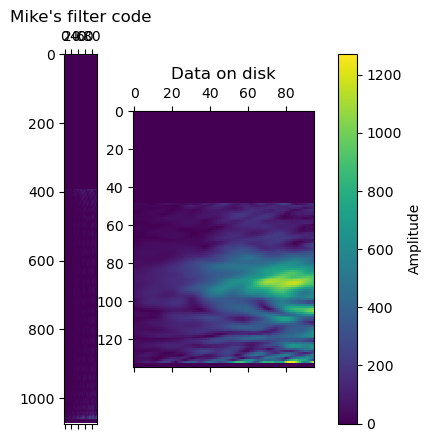

In [112]:
fig, ax = plt.subplots(ncols=2)

im = ax[0].matshow(np.abs(filt_dat))
ax[0].set_title("Mike's filter code")
ax[1].matshow(np.abs(pipeline_filt_dat))
ax[1].set_title("Data on disk")
fig.colorbar(im, ax=ax.ravel().tolist(), label="Amplitude")

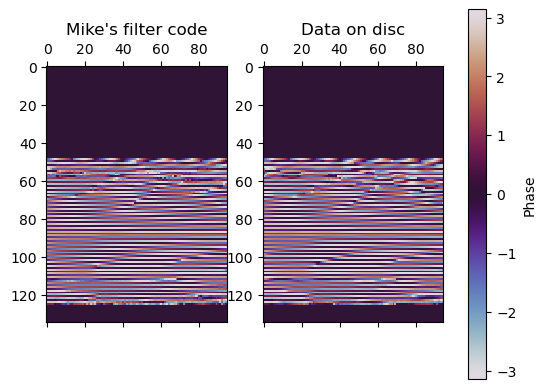

In [89]:
fig, ax = plt.subplots(ncols=2)

im = ax[0].matshow(np.angle(filt_dat), cmap="twilight")
ax[0].set_title("Mike's filter code")
ax[1].matshow(np.angle(pipeline_filt_dat), cmap="twilight")
ax[1].set_title("Data on disc")
fig.colorbar(im, ax=ax.ravel().tolist(), label="Phase")

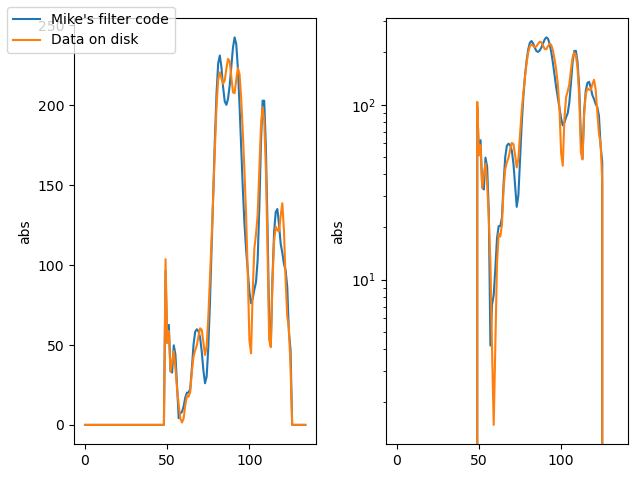

In [90]:
def plot_slice_comparison(freq_chan=40, attr="abs", interleave_disk=False, save=False):


    fig, ax = plt.subplots(ncols=2)
    labels = ["Mike's filter code", "Data on disk"]

    for ax_ind, ax_ob in enumerate(ax):

        ax_ob.plot(getattr(np, attr)(filt_dat)[:, freq_chan], label=labels[0])
        if interleave_disk:
            lines = ax_ob.plot(getattr(np, attr)(pipeline_filt_dat)[::4, freq_chan], label=labels[1])
        else:
            lines = ax_ob.plot(getattr(np, attr)(pipeline_filt_dat)[:, freq_chan], label=labels[1])
        ax_ob.set_ylabel(attr)
        if ax_ind > 0 and attr == "abs":
            ax_ob.set_yscale("log")

    fig.legend(labels, loc="upper left")
    fig.tight_layout()
    
    if save:
        fig.savefig(f"{outdir}/filter_{attr}_slice_comparison.png")
    
    return

plot_slice_comparison(interleave_disk=False, save=True)

In [59]:
np.fft.fftfreq??

In [119]:
from scipy.signal import blackmanharris

In [138]:
uf_uvd = UVData.from_file(unfiltered_waterfall_file)
print(uf_uvd.data_array.shape)

(4296, 1, 95, 2)


In [147]:


Ntimes = filt_dat.shape[0]
frs = np.fft.fftfreq(Ntimes, d=40e-3)

frs = np.fft.fftshift(frs)
bh = blackmanharris(Ntimes)

def get_ps(dat):
    return np.fft.fftshift(np.abs(np.fft.fft(bh[:, np.newaxis] * dat, axis=0))**2)

frps = get_ps(filt_dat)
frps_uf = get_ps(uf_uvd.data_array[::4, 0, :, 1] * np.logical_not(uf_uvd.flag_array[::4, 0, :, 1]).astype(float))
#pipeline_frps = get_ps(pipeline_filt_dat)

In [123]:
filt_params = get_filt_params(antpair, spw)

In [124]:
print(filt_params)

(-0.0015097697044130004, 0.00031217896890839306)


In [131]:
print(slc)

slice(537, 537, None)


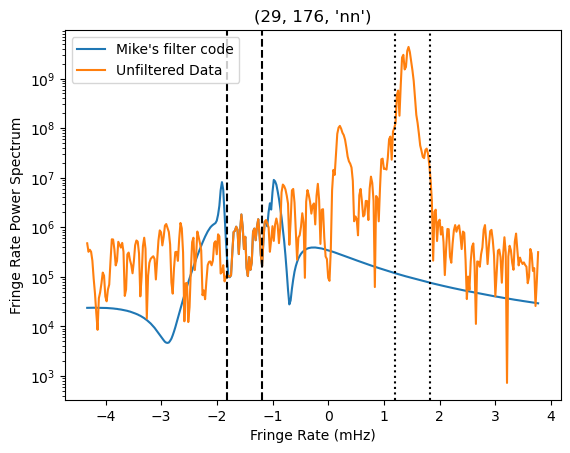

In [150]:
freq_chan = 20
left_rate = filt_params[0] - filt_params[1]
right_rate = filt_params[0] + filt_params[1]
left_index = np.argmin(np.abs(frs - (left_rate - 8 * filt_params[1])*1e3))
right_index = np.argmin(np.abs(frs - (right_rate + 16 * filt_params[1]) * 1e3))
slc = slice(left_index, right_index)

plt.plot(frs[slc], frps[slc, freq_chan], label="Mike's filter code")
plt.plot(frs[slc], frps_uf[slc, freq_chan], label="Unfiltered Data")
#plt.plot(frs, pipeline_frps[:, freq_chan], label="Mike's filter code")
plt.axvline((left_rate) * 1e3, linestyle="--", color="black")
plt.axvline((right_rate) * 1e3, linestyle="--", color="black")
plt.axvline(-(left_rate) * 1e3, linestyle=":", color="black")
plt.axvline(-(right_rate) * 1e3, linestyle=":", color="black")
plt.yscale("log")
plt.ylabel("Fringe Rate Power Spectrum")
plt.xlabel("Fringe Rate (mHz)")
plt.legend()
plt.title(antpairpol)
plt.savefig(f"{outdir}/fringe_rate_ps_plot_high_cadence_{antpair[0]}_{antpair[1]}_{antpairpol[2]}.png")

In [153]:
uf_uvd.uvw_array[0, :3]

array([-131.92146489,  117.5713906 ,   -1.19153827])

4296


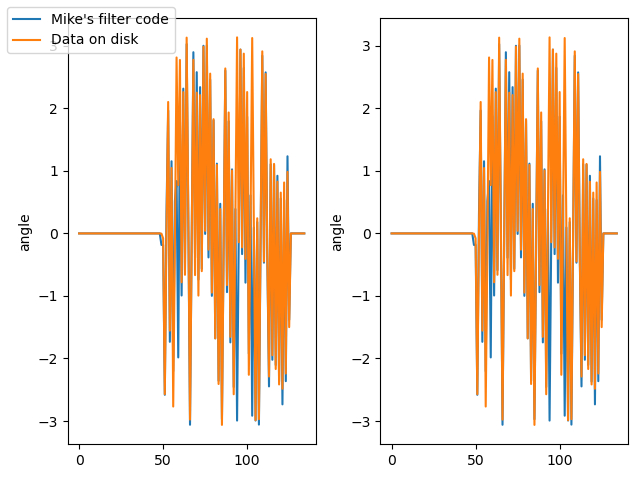

In [42]:
plot_slice_comparison(attr="angle")

### Complex correlation coefficient

In [44]:
freq_chan = 40

In [45]:
np.corrcoef(filt_dat[50:120, freq_chan], pipeline_filt_dat[50:120, freq_chan])

array([[1.      -2.42944330e-18j, 0.987252+2.20745037e-03j],
       [0.987252-2.20745037e-03j, 1.      +1.50887165e-18j]])

### Amplitude correlation coefficient



In [46]:
np.corrcoef(np.abs(filt_dat)[50:120, freq_chan], np.abs(pipeline_filt_dat)[50:120, freq_chan])

array([[1.        , 0.97790836],
       [0.97790836, 1.        ]])

### Phase correlation coefficient

In [47]:
np.corrcoef(np.angle(filt_dat)[50:120, freq_chan], np.angle(pipeline_filt_dat)[50:120, freq_chan])

array([[1.        , 0.82885175],
       [0.82885175, 1.        ]])

### Histogram of fractional residuals

Text(0.5, 0, 'Fractional Residual')

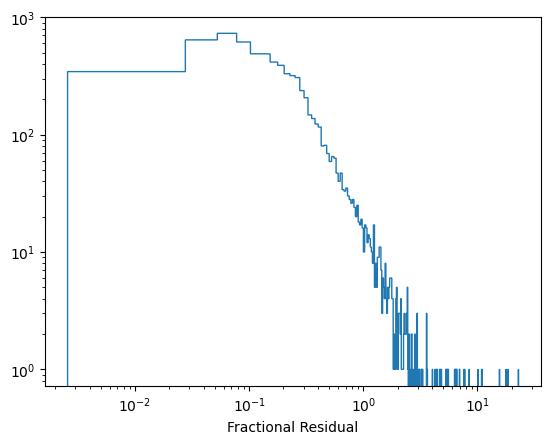

In [50]:
frac_resid = np.abs(1 - filt_dat / pipeline_filt_dat)
frac_resid = frac_resid[np.logical_not(np.isnan(frac_resid))]

plt.hist(frac_resid, bins="auto", histtype="step", log=True)
plt.xscale("log")
plt.xlabel("Fractional Residual")

# What types of errors are most relevant for covariance estimation?

# Below here are some old tests and scratch paper. No need to venture this far down.

In [ ]:
def read_files(indir="/lustre/aoc/projects/hera/H4C/lstbin/before_filtering_before_red_averaging/full_band_include_variable_ants",
               read_anew=False, Nfiles=125, tag="_FRF_test"):
    """
    Helper function to read in some files I wrote in an older version of this notebook.
    """


    uvd_files = glob.glob(f"{indir}/*sum.uvh5")


    uvd = UVData()
    outfile = f"/lustre/aoc/projects/hera/mwilensk/ebars/LSTbin_{Nfiles}{tag}.uvh5"

    if read_anew:
        uvd.read(uvd_files[:Nfiles], antenna_nums=ants_dat, freq_chans=np.arange(95), polarizations=[-5])
        uvd.write_uvh5(outfile)


    hd = HERAData(outfile)
    hd.read()  
    
    return hd


In [4]:
size = (135, 1074, 95)
fop = np.random.normal(size=size)
fvaris_right = np.random.normal(size=size)


In [5]:
%timeit cov = (fop[:, np.newaxis] * fvaris_right).sum(axis=2)

8.26 s ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit cov = np.einsum("ijk,ljk->ilk", fop, fvaris_right, optimize=True)

2.39 s ± 6.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default value of 1


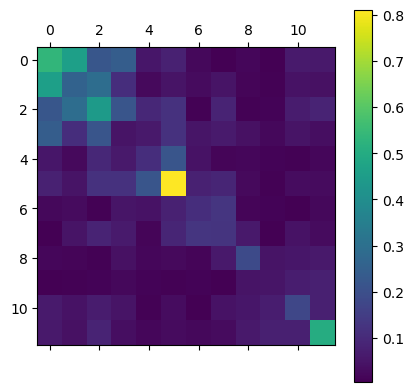

In [79]:
hd = read_files()
cov = get_covs_antpair(hd, 0, 200, (3,5, "nn"), weights=None)

plt.matshow(np.abs(cov[0][:, :, 40]))
plt.colorbar()

Some channels are entirely flagged. Giving them uniform weighting.
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide
Replacing nans with default value of 1


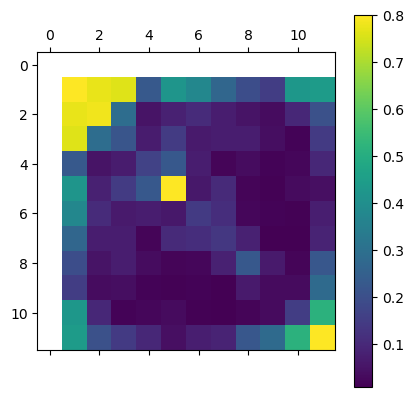

In [81]:
hd = read_files()
cov = get_covs_antpair(hd, 0, 200, (3,5, "nn"), weights="flags")

plt.matshow(np.abs(cov[0][:, :, 40]), vmax=0.8)
plt.colorbar()

In [72]:

weights = get_covs_antpair(hd, 0, 200, (3,5, "nn"), weights="flags")

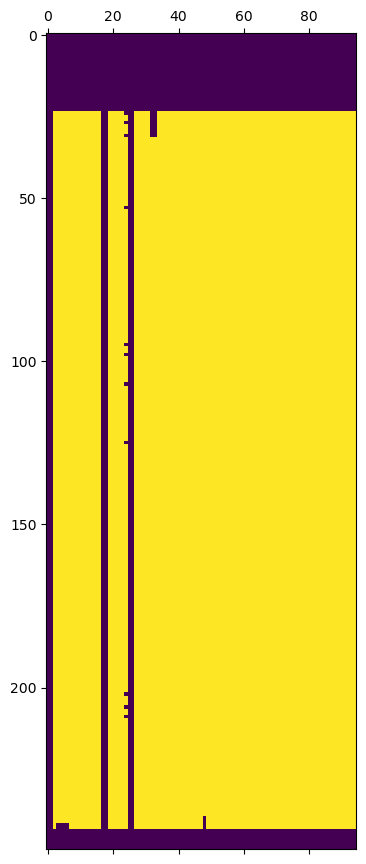

In [73]:
plt.matshow(weights)

### Comparing to Rajorshi's realizations

In [5]:
rajdir = "/lustre/aoc/projects/hera/rchandra"
noise_rzn_subdir = "Raj_UVH5_PSPECH5_Rlzn_NO_FRF_TAVG_INTRLV_Files_2"

noise_rzn_dir = f"{rajdir}/{noise_rzn_subdir}/H4C_SIM_NOISE_Chunked_RedGrp_NO_RedBlAvg_TAVG_FRF_UVH5"
noise_rzn_files = sorted(glob.glob(f"{noise_rzn_dir}/*run1*.uvh5"))
file_prefix = "VisGen_Raj_5_run1_noise_vis_28_90_ee_nn_"
Nrzn = len(noise_rzn_files)
print(Nrzn)


100


In [6]:
%%capture
hd_meta = HERAData(noise_rzn_files[0])


In [7]:
print(hd_meta.antpairs)
print(hd_meta.Ntimes)

[(5, 29), (13, 39), (24, 52), (25, 53), (36, 66), (50, 82), (53, 85), (66, 100), (68, 102), (81, 117), (82, 118), (83, 119), (87, 123), (88, 124), (92, 128), (94, 130), (98, 136), (102, 140), (103, 141), (105, 143), (109, 147), (127, 167), (128, 168), (130, 170), (148, 189), (149, 190)]
20


### Copied cells from Rajorshi's notebook


In [8]:
data_path = "/lustre/aoc/projects/hera/rchandra/Raj_UVH5_PSPECH5_Rlzn_NO_FRF_TAVG_INTRLV_Files_2/H4C_OBS_DATA_Chunked_No_RedBlAvg_TAVG_FRF_UVH5/"

suffix = "zen.LST.*.sum.all-bands-allbls-long-delay-clean-include-variable-ants.foreground_filled.xtalk_filtered.chunked.uvh5"

In [9]:
### Get file list

# 1. Query the file terms
mylist = sorted([f for f in glob.glob(os.path.join(data_path, "*" + suffix))])

### Modified the next cell based on what I know is in the  because I wasn't comfortable copying/pasting a bunch of pspec stuff

In [10]:
print(mylist[:2])

['/lustre/aoc/projects/hera/rchandra/Raj_UVH5_PSPECH5_Rlzn_NO_FRF_TAVG_INTRLV_Files_2/H4C_OBS_DATA_Chunked_No_RedBlAvg_TAVG_FRF_UVH5/zen.LST.0.00000.sum.all-bands-allbls-long-delay-clean-include-variable-ants.foreground_filled.xtalk_filtered.chunked.uvh5', '/lustre/aoc/projects/hera/rchandra/Raj_UVH5_PSPECH5_Rlzn_NO_FRF_TAVG_INTRLV_Files_2/H4C_OBS_DATA_Chunked_No_RedBlAvg_TAVG_FRF_UVH5/zen.LST.0.01409.sum.all-bands-allbls-long-delay-clean-include-variable-ants.foreground_filled.xtalk_filtered.chunked.uvh5']


In [11]:
print("Reading files ...")

#redgrp_pol = [antpair + ("nn", ) for antpair in hd_meta.antpairs] + [antpair + ("ee", ) for antpair in hd_meta.antpairs]
antpairpols = [(5, 29, "nn"), ]
antpairpol = antpairpols[0]

numof_LST_files = 10
hd = HERAData(mylist[0:numof_LST_files], bls=antpairpols, frequencies=hd_meta.freq_array[:95])

data, flags, nsamples = hd.read(bls=antpairpols, frequencies=hd_meta.freq_array[:95])

print("File load completed!")



Reading files ...
File load completed!


In [12]:
print(hd.Ntimes)

200


In [13]:

chunk_size = 25
spw = 0

cov_test = get_covs_antpair(hd, spw, chunk_size, antpairpols[0], weights=None, default_value=1)

Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or 

(200, 737)


# Covariance for 0th frequency channel for antpairpol (5, 29, nn) after FRF and coherent averaging (200 integrations, 25 integrations per bin)

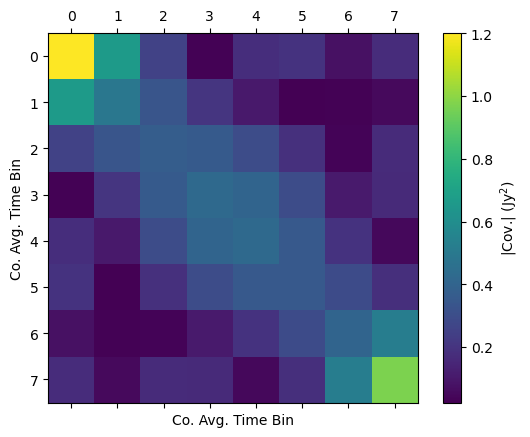

In [14]:
def plot_cov(fig, ax, cov, title="", vmin=0, vmax=1.2):

    im =  ax.matshow(np.abs(cov))
    ax.set_xlabel("Co. Avg. Time Bin")
    ax.set_ylabel("Co. Avg. Time Bin")
    ax.set_title(title)

    
    return im

fig, ax = plt.subplots()
im = plot_cov(fig, ax, cov_test[0])
fig.colorbar(im, label=r"|Cov.| (Jy$^2$)")

In [29]:


filter_center, filter_half_width, eval_cutoff = get_filt_params(antpairpol[:2], spw, eval_cutoff=1e-9)

filt_dat = np.zeros([Nrzn, hd.Ntimes // chunk_size, 95], dtype=complex)
for rzn_ind in range(Nrzn):
    rzn_file = noise_rzn_files[rzn_ind]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        hd_rzn = HERAData(rzn_file)
        data_rzn, _, _, = hd_rzn.read(bls=antpairpols, frequencies=hd_rzn.freq_array[:95])
    fop = get_fop(hd, filter_center, filter_half_width, eval_cutoff, chunk_size)
    

    filt_dat_rzn = fop @ data_rzn[antpairpol]

    filt_dat[rzn_ind] = filt_dat_rzn

    

In [30]:


np.save(f"{outdir}/raj_filt_noise.npy", filt_dat)

In [17]:
filt_dat = np.load(f"{outdir}/raj_filt_noise.npy")

In [61]:
def get_cest(freq_chan):

    fdchan = filt_dat[:, :, freq_chan]

    outer = fdchan[:, :, np.newaxis] * fdchan.conj()[:, np.newaxis, :]
    cest = outer.mean(axis=0)
    cquant = np.quantile(outer, [norm.cdf(-1), norm.cdf(1)], axis=0)
    
    return cest, cquant

cest, cquant = get_cest(0)

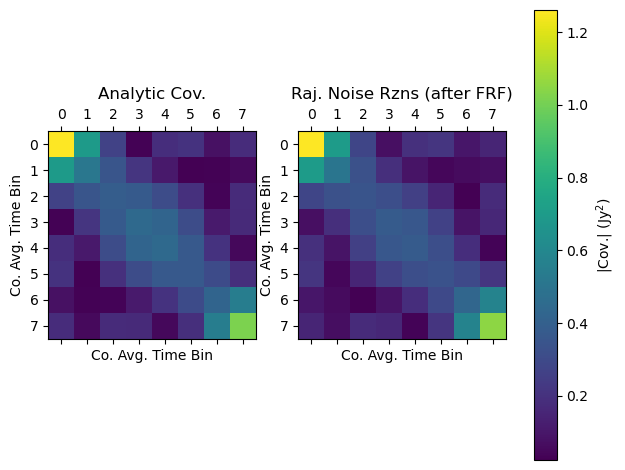

In [62]:
fig, ax = plt.subplots(ncols=2)

_ = plot_cov(fig, ax[0], cov_test[0], title="Analytic Cov.")
im = plot_cov(fig, ax[1], cest, title="Raj. Noise Rzns (after FRF)")
fig.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist(), label=r"|Cov.| (Jy$^2$)")

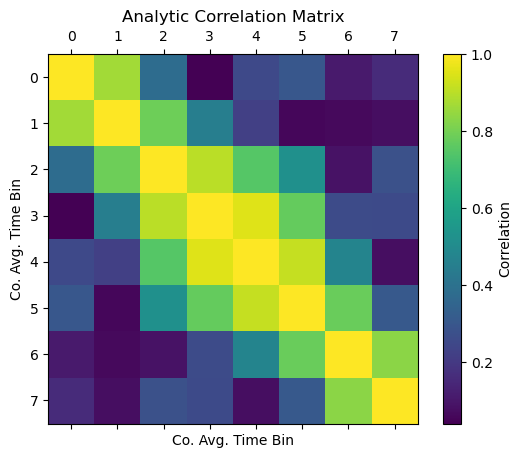

In [20]:
ctd = np.diag(cov_test[0].real)
corr = cov_test[0] / np.sqrt(np.outer(ctd, ctd))

fig, ax = plt.subplots()
im = plot_cov(fig, ax, corr, title="Analytic Correlation Matrix", vmin=0, vmax=1)
fig.colorbar(im, label=r"Correlation")


# Plot some of the filtered noise realizations

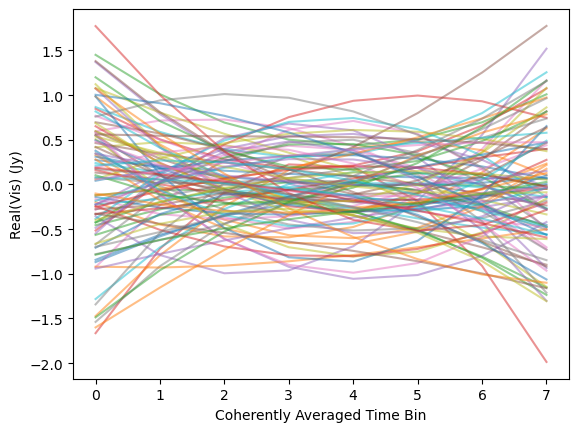

In [21]:
plt.plot(filt_dat[:, :, 0].T.real, alpha=0.5)
plt.ylabel("Real(Vis) (Jy)")
plt.xlabel("Coherently Averaged Time Bin")
None

In [28]:
def get_analytic_cests(freq_chan, ridge=1e-15, Nmeans=100):

    cov_test_cho = cholesky(cov_test[freq_chan] + np.diag(np.full(8, ridge)), lower=True)
    std_norm = np.random.normal(size=(8, Nrzn, Nmeans))
    analytic_rzns = np.tensordot(cov_test_cho, std_norm, axes=1)
    analytic_outers = analytic_rzns[:, np.newaxis] * analytic_rzns[np.newaxis].conj()
    analytic_cests = np.mean(analytic_outers, axis=-2)
    cquants = np.quantile(analytic_cests, [norm.cdf(-1), norm.cdf(1)], axis=-1)
    
    return cquants, analytic_cests

cquants, analytic_cests = get_analytic_cests(0)

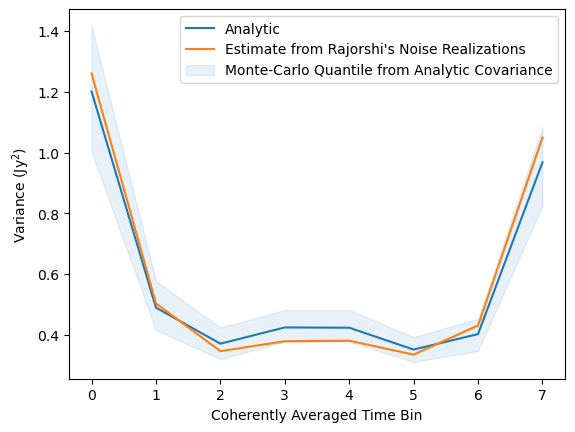

In [24]:
plt.plot(np.diag(cov_test[0]).real, label="Analytic")
plt.plot(np.diag(cest).real, label="Estimate from Rajorshi's Noise Realizations")
plt.fill_between(np.arange(8), np.diag(cquants[0]).real, np.diag(cquants[1]).real, color="tab:blue", alpha=0.1, 
                 label="Monte-Carlo Quantile from Analytic Covariance")
plt.xlabel("Coherently Averaged Time Bin")
plt.ylabel(r"Variance (Jy$^2$)")
plt.legend()

Text(0.5, 1.0, 'Monte-Carlo Variance Correlation')

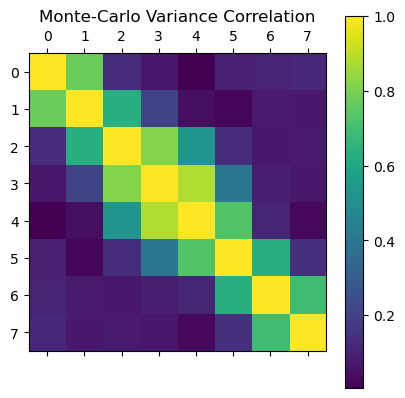

In [25]:
varcov = np.cov(analytic_cests[np.arange(8), np.arange(8)])
dvc = np.diag(varcov)

varcorr = varcov / np.sqrt(np.outer(dvc, dvc))
rot = 1 / np.sum(np.abs(varcorr)) * 8**2

plt.matshow(np.abs(varcorr.real))
plt.colorbar()
plt.title("Monte-Carlo Variance Correlation")

In [64]:
chisqs = []
sumsqs = []
sumsqs_analytic = []

for freq_chan in range(95):
    cest_freq, _ = get_cest(freq_chan)
    _, analytic_cest_freq = get_analytic_cests(freq_chan, ridge=1e-13)
    varcov = np.cov(analytic_cest_freq[np.arange(8), np.arange(8)])
    vardiff = np.diag(cov_test[freq_chan]).real - np.diag(cest_freq).real
    vardiff_analytic = np.diag(cov_test[freq_chan]).real - analytic_cest_freq[np.arange(8), np.arange(8), 0].real
    
    sumsq = np.sum(np.abs(vardiff)**2)
    sumsqs.append(sumsq)
    
    sumsq_analytic = np.sum(np.abs(vardiff_analytic)**2)
    
    
    sumsqs_analytic.append(sumsq_analytic)
    

    chisq = vardiff @ np.linalg.solve(varcov, vardiff)
    chisqs.append(chisq.real)

kstest: KstestResult(statistic=0.15789473684210525, pvalue=0.18761407787239476, statistic_location=56.32278238735823, statistic_sign=1)


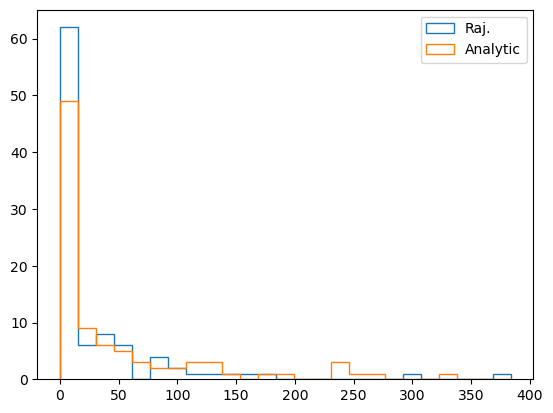

In [72]:
_, bins, _ = plt.hist(sumsqs, bins="auto", histtype="step", label="Raj.")
plt.hist(sumsqs_analytic, bins=bins, histtype="step", label="Analytic")
plt.legend()
print(f"kstest: {kstest(sumsqs, sumsqs_analytic)}")

# Open question: 

- I used all my own code (but Bobby's params and hera_filters/hera_cal var estimate), and showed that it was all self-consistent (good math check).  
- *Still need to ensure that my filter operator mirrors what actually gets applied to the data in the HERA pipeline.*
- Probably best way to do this is actually just to inject parts of my code (e.g. variance setup) into the HERA pipeline, but using the filter ope

In [42]:
rootdir = "/lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average"
branchdir = "4-way-interleave"

indir = f"{rootdir}/{branchdir}"

files = glob.glob(f"{indir}/*sum*chunked.uvh5")




In [44]:
auto_list = []
auto_file_list = []
Ntimes_list = []
for file in files:
    uvd = UVData()
    try:
        uvd.read(file, read_data=True, ant_str="auto")
    except ValueError:
        continue
    where_auto = np.where(uvd.ant_1_array == uvd.ant_2_array)
    if np.any(where_auto):
        print(f"found some autos in {file}")
        auto_file_list.append(file)
        autos, counts = np.unique(uvd.ant_1_array[where_auto], return_counts=True)
        auto_list.extend(autos)
        Ntimes_list.extend(counts)
        print(np.any(uvd.data_array[where_auto] != 0))

found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.6.25782.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.0.52148.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.1.55036.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.5.75043.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing

found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.1.63492.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.0.74699.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.5.80680.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing/lstbin/after_filtering_before_red_average/4-way-interleave/zen.LST.5.70814.sum.include-variable-ants-interleave-4-way.foreground_filled.xtalk_filtered.chunked.uvh5
True
found some autos in /lustre/aoc/projects/hera/H4C/postprocessing

KeyboardInterrupt: 

In [45]:
print(auto_list)
print(Ntimes_list)

[3, 5, 11, 13, 15, 17, 24, 25, 29, 36, 39, 44, 45, 46, 50, 52, 53, 58, 59, 66, 68, 73, 81, 82, 83, 85, 87, 88, 91, 92, 94, 98, 99, 100, 102, 103, 104, 105, 108, 109, 111, 112, 117, 118, 119, 120, 122, 123, 124, 127, 128, 129, 130, 135, 136, 138, 140, 141, 143, 144, 145, 147, 148, 149, 156, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 3, 5, 11, 13, 15, 17, 24, 25, 29, 36, 39, 44, 45, 46, 50, 52, 53, 58, 59, 66, 68, 73, 81, 82, 83, 85, 87, 88, 91, 92, 94, 98, 99, 100, 102, 103, 104, 105, 108, 109, 111, 112, 117, 118, 119, 120, 122, 123, 124, 127, 128, 129, 130, 135, 136, 138, 140, 141, 143, 144, 145, 147, 148, 149, 156, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 3, 5, 11, 13, 15, 17, 24, 25, 29, 36, 39, 44, 45, 46, 50, 52, 53, 58, 59, 66, 68, 73, 81, 82, 83, 85, 87, 88, 91, 92, 94, 98, 99, 100, 102, 103, 104, 105, 108,

In [47]:
print(len(auto_file_list))

63


In [50]:
print(files.index(file))

63


In [59]:
%%time

uvd.read(file, read_data=True, ant_str="auto")

CPU times: user 4.94 s, sys: 301 ms, total: 5.24 s
Wall time: 5.25 s


In [63]:
%%time

uvd.read(files[61], read_data=False, ant_str="auto")

CPU times: user 144 ms, sys: 5.06 ms, total: 149 ms
Wall time: 151 ms


In [71]:


num_autos = 0
autos_in_files = []
for file in files:
    uvd.read(file, read_data=False, ant_str="auto")
    where_autos = np.where(uvd.ant_1_array == uvd.ant_2_array)
    autos_in_file = np.unique(uvd.ant_1_array[where_autos])
    autos_in_files.append(autos_in_file)

In [72]:
len(np.unique(autos_in_files))

91

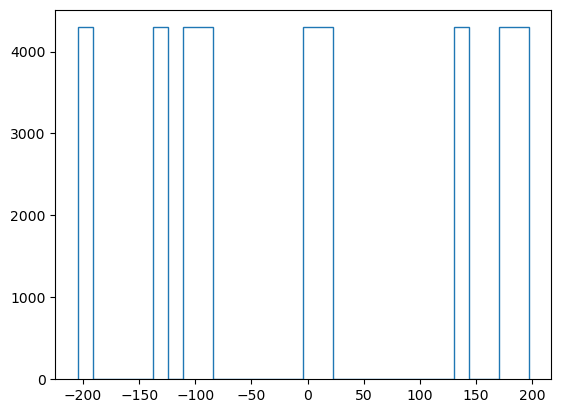

In [20]:
plt.hist(uvd.uvw_array[:, 0], bins="auto", histtype="step")
None

In [21]:
np.any(uvd.ant_1_array == uvd.ant_2_array)

False

In [22]:
np.amin(np.sqrt(uvd.uvw_array**2).sum(axis=1))

42.713713109946895

In [ ]:
print("yes")

In [73]:
help(UVData.__add__)

Help on function __add__ in module pyuvdata.uvdata.uvdata:

__add__(self, other, inplace=False, phase_center_radec=None, unphase_to_drift=None, phase_frame=None, orig_phase_frame=None, use_ant_pos=None, verbose_history=False, run_check=True, check_extra=True, run_check_acceptability=True, strict_uvw_antpos_check=False, make_multi_phase=None, ignore_name=False)
    Combine two UVData objects along frequency, polarization and/or baseline-time.
    
    Parameters
    ----------
    other : UVData object
        Another UVData object which will be added to self.
    inplace : bool
        If True, overwrite self as we go, otherwise create a third object
        as the sum of the two.
    phase_center_radec : array_like of float
        Deprecated and will be removed in version 2.4, instead call `phase` on the
        combined object after this method. The phase center to phase the files to
        before adding the objects in radians.
    unphase_to_drift : bool
        Deprecated, instea

In [76]:
main_uvd = UVData()
main_uvd.read(files[0], ant_str="auto")
for file in files[1:]:
    print(f"working on file no. {files.index(file)}")
    new_uvd = UVData()
    new_uvd.read(file, ant_str="auto")
    main_uvd.__add__(new_uvd, inplace=True)
    
    

working on file no. 1


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 2


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 3


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 4


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 5


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 6


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 7


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 8


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 9


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 10


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 11


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 12


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 13


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 14


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 15


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 16


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 17


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 18


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 19


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 20


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 21


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 22


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 23


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 24


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 25


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 26


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 27


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 28


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 29


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 30


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 31


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 32


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 33


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 34


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 35


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 36


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 37


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 38


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 39


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 40


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 41


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 42


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 43


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 44


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 45


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 46


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 47


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 48


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 49


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 50


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 51


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 52


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 53


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 54


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 55


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 56


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 57


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 58


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 59


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 60


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 61


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 62


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 63


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 64


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 65


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 66


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 67


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 68


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 69


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 70


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 71


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 72


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 73


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 74


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 75


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 76


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 77


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 78


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 79


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 80


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 81


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 82


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 83


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 84


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 85


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 86


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 87


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 88


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 89


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 90


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 91


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 92


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 93


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 94


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 95


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 96


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 97


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 98


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 99


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 100


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 101


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 102


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 103


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 104


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 105


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 106


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 107


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 108


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 109


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 110


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 111


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 112


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 113


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 114


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 115


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 116


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 117


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 118


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 119


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 120


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 121


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 122


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 123


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 124


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 125


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 126


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 127


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 128


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 129


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 130


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 131


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 132


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 133


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 134


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 135


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 136


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 137


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 138


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 139


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 140


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 141


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 142


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 143


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 144


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 145


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 146


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 147


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 148


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 149


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 150


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 151


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 152


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 153


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 154


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 155


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 156


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 157


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 158


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 159


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 160


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 161


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 162


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 163


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 164


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 165


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 166


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 167


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 168


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 169


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 170


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 171


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 172


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 173


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 174


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 175


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 176


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 177


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 178


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 179


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 180


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 181


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 182


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 183


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 184


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 185


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 186


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 187


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 188


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 189


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 190


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 191


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 192


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 193


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 194


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 195


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 196


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 197


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 198


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 199


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 200


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 201


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 202


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 203


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 204


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 205


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 206


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 207


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 208


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 209


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 210


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 211


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 212


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 213


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


working on file no. 214


Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


In [77]:
main_uvd.write_uvh5(f"{outdir}/chunked_autos.uvh5")

In [78]:
main_uvd.Ntimes

4296

In [80]:
main_uvd.Nblts // main_uvd.Nbls

4296

In [81]:
main_uvd.Nfreqs

737

In [3]:
auto_uvd = UVData.from_file(f"{outdir}/chunked_autos.uvh5")

In [5]:
print(np.all(auto_uvd.data_array > 0))

False


In [20]:
mean = auto_uvd.data_array.reshape(auto_uvd.Ntimes, auto_uvd.Nbls, auto_uvd.Nfreqs, auto_uvd.Npols).mean(axis=1)

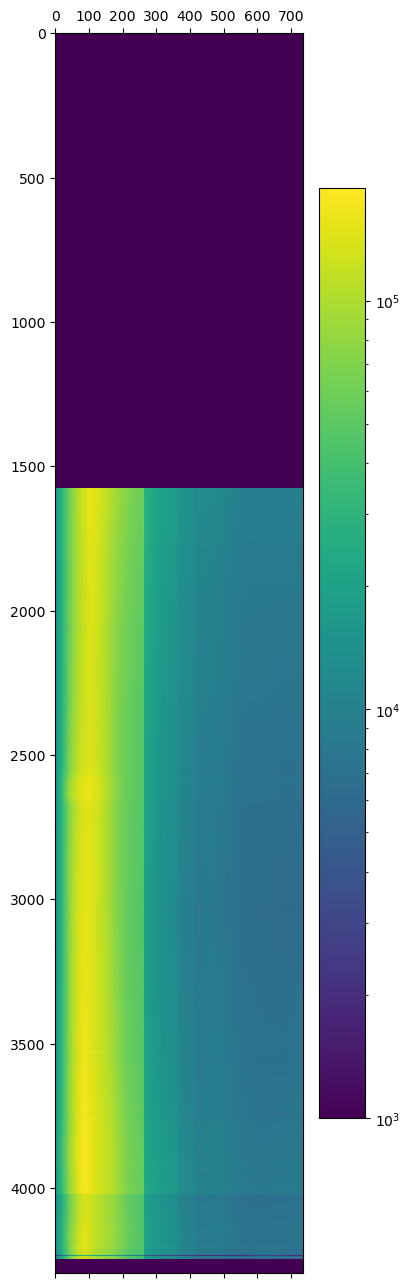

In [21]:
plt.matshow(np.abs(mean[:, :, 0]), aspect="auto", norm=LogNorm(vmin=1e3))
plt.colorbar()

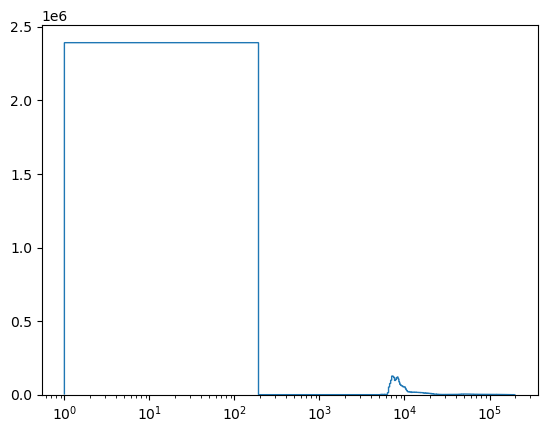

In [17]:
plt.hist(np.abs(mean).flatten(), bins="auto", histtype="step")
plt.xscale("log")
None

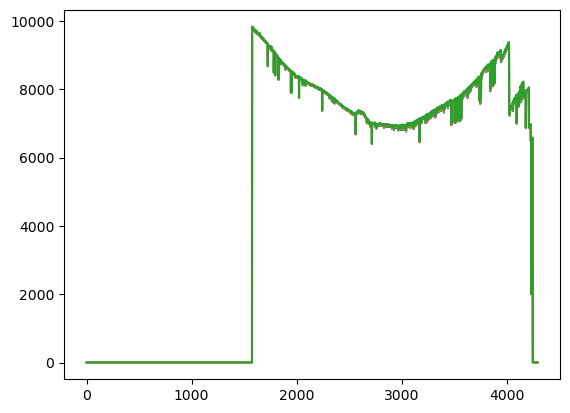

In [22]:
plt.plot(np.abs(mean)[:, -3:, 0])